In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os

# Read and reformat data from FROST
The data can be downloaded using get_weather_station.py

In [12]:
files = os.listdir('./stations')
files.remove('meta_data.pkl') #not a station

In [14]:
files = os.listdir('./stations')
stations = []
for id_ in files:
    stations.append(xr.open_dataset("./stations/"+id_))

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html
http://xarray.pydata.org/en/stable/user-guide/io.html

In [15]:
# string datatype was lost in export, this loop fixes these strings. 
for station in stations:
    station['id'] = station['id'].astype(str)
    station['name'] = station['name'].astype(str)
    station['shortname'] = station['shortname'].astype(str)
    station['latitude'] = float(station['latitude'])
    station['longitude'] = float(station['longitude'])
    station['maxResolution'] = station['maxResolution'].astype(str)

KeyError: 'maxResolution'

# Interpolate and plot map

In [5]:
from geostat import OrdinaryKriging # my own module

x_data = np.array([stat['longitude'] for stat in stations])
y_data = np.array([stat['latitude'] for stat in stations])
p_data = np.array([stat['PT1H'] for stat in stations])

resolution = 100 # grid for plotting weather stations
frame = 0.1

x_grid = np.linspace(x_data.min() - frame, x_data.max() + frame, resolution)
y_grid = np.flip(np.linspace(y_data.min() - frame, y_data.max() + frame, resolution))

min_lat = y_data.min() - frame
max_lat = y_data.max() + frame
min_lon = x_data.min() - frame
max_lon = x_data.max() + frame

In [6]:
p_data

array([[0.6, 1.1, 0.2, 0.1, 0.9, 0.2, 0. ],
       [0.3, 0.6, 2.1, 2. , 0.3, 0.2, 0. ],
       [0.2, 0.6, 2.1, 1.9, 0.4, 0.1, 0. ],
       [1.6, 1.4, 0.9, 2.2, 2.1, 0.1, 0.1],
       [2.1, 1.5, 0.9, 2. , 1. , 0.2, 0.1],
       [0.2, 0.8, 1.5, 3. , 0.4, 0. , 0. ],
       [1.6, 0.9, 1.7, 4.3, 1.1, 0.4, 0.1]])

In [7]:
stations

[<xarray.Dataset>
 Dimensions:        (time: 7)
 Coordinates:
   * time           (time) object '2018-08-08T08:00:00.000Z' ... '2018-08-08T1...
     latitude       float64 59.59
     longitude      float64 11.1
     maxResolution  <U4 'PT1H'
     shortname      <U10 'Kykkelsrud'
     id             <U6 'SN3720'
     name           <U18 'ASKIM - KYKKELSRUD'
 Data variables:
     PT1H           (time) float64 0.6 1.1 0.2 0.1 0.9 0.2 0.0,
 <xarray.Dataset>
 Dimensions:        (time: 7)
 Coordinates:
   * time           (time) object '2018-08-08T08:00:00.000Z' ... '2018-08-08T1...
     latitude       float64 59.74
     longitude      float64 10.59
     maxResolution  <U4 'PT1H'
     shortname      <U11 'Fagerstrand'
     id             <U7 'SN17775'
     name           <U11 'FAGERSTRAND'
 Data variables:
     PT1H           (time) float64 0.3 0.6 2.1 2.0 0.3 0.2 0.0,
 <xarray.Dataset>
 Dimensions:        (time: 7)
 Coordinates:
   * time           (time) object '2018-08-08T08:00:00.000Z' .

### Kriging interpolation

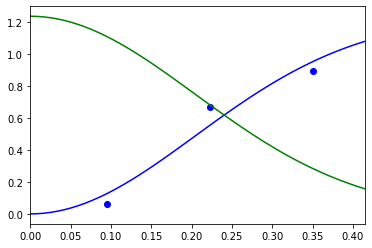

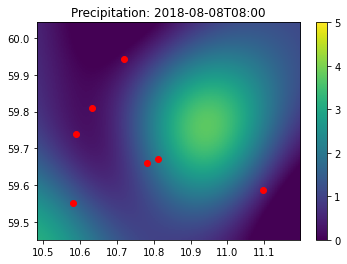

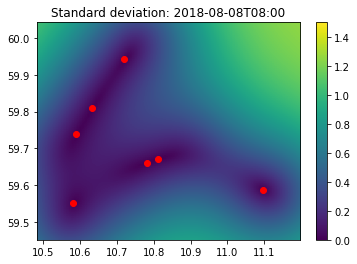

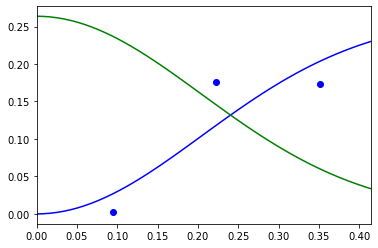

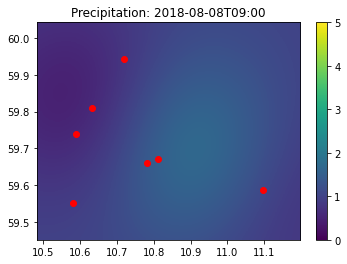

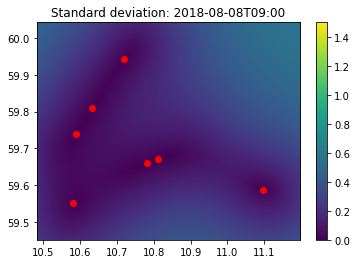

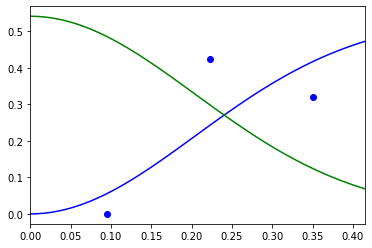

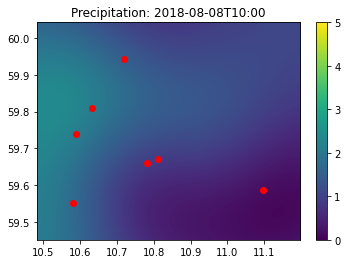

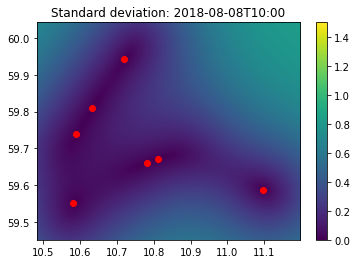

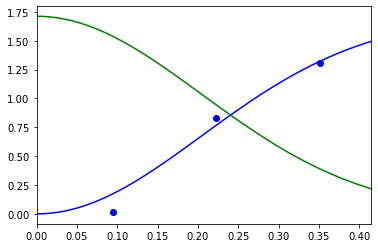

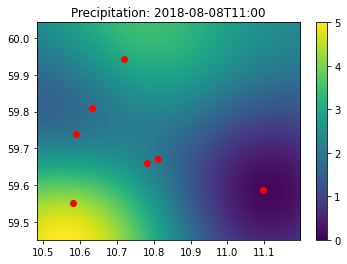

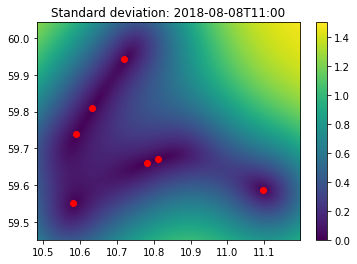

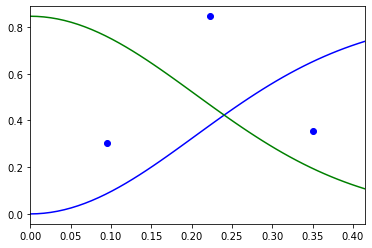

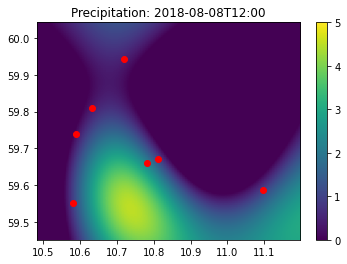

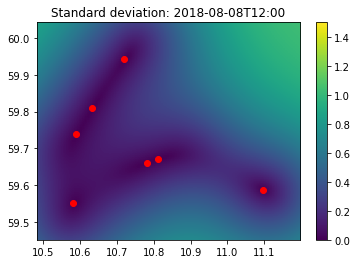

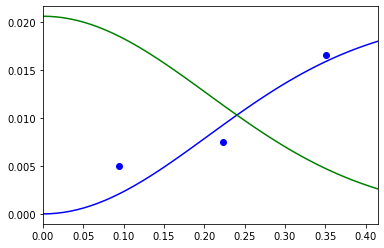

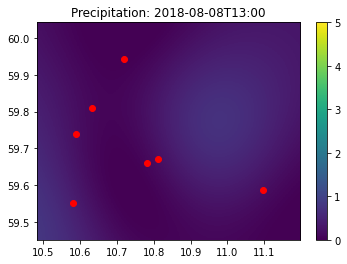

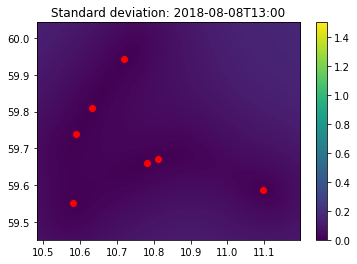

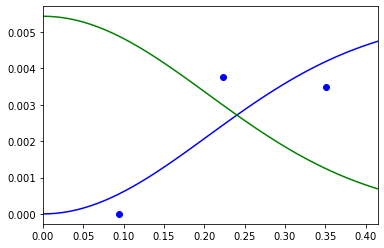

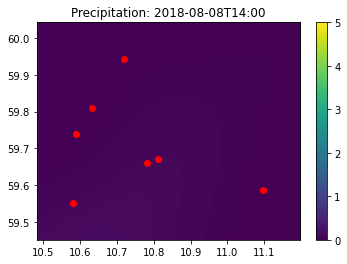

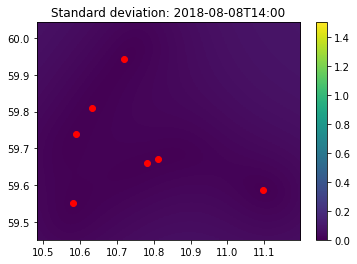

In [18]:
from geostat import OrdinaryKriging # my own module

for t_i in range(len(stations[0]['time'])): # time index
    p = p_data[:, t_i]
    OK = OrdinaryKriging(
        x_data, #x-values
        y_data, #y-values
        p, #
        variogram_parameters = [-3, 2, 0.5, 0], #[alpha, beta, hr, c0]
        enable_plotting=True, 
        n_bins = 4, #number of averaging bins
    )

    z_grid_intp, z_grid_sigma = OK.predict(x_grid, y_grid)
    plt.imshow(z_grid_intp, extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()],
           vmin=z_grid_intp.min(), vmax=z_grid_intp.max())
    plt.clim(0,5)
    plt.colorbar()
    
    plt.title("Precipitation: " + stations[0].time.values[t_i][0:16])
    plt.scatter(x_data, y_data, c='red', marker='o')
    plt.show()
    
    
    plt.imshow(z_grid_sigma, extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()],
           vmin=z_grid_intp.min(), vmax=z_grid_intp.max())
    plt.clim(0,1.5)
    plt.colorbar()
    plt.title("Standard deviation: " + stations[0].time.values[t_i][0:16])
    plt.scatter(x_data, y_data, c='red', marker='o')
    plt.show()

### Verify by pykrige

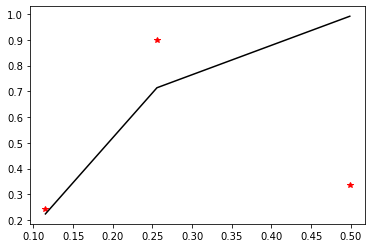

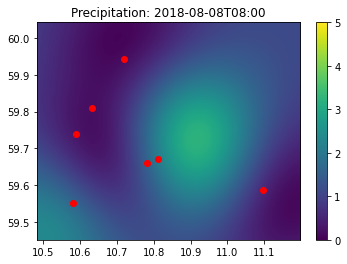

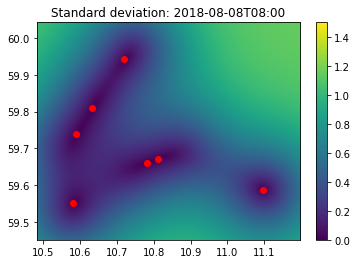

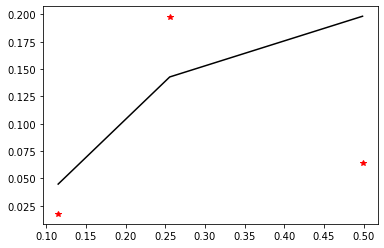

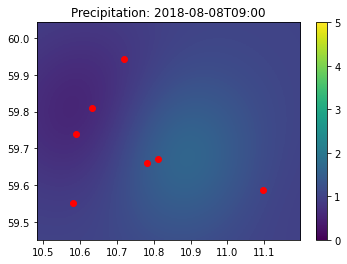

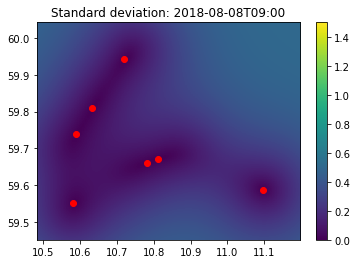

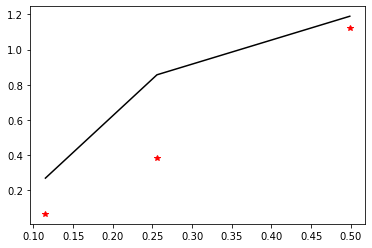

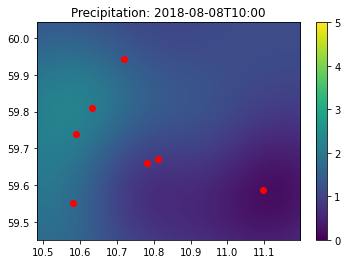

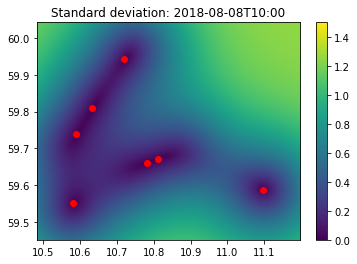

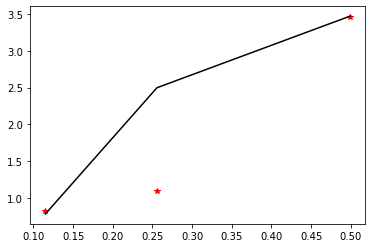

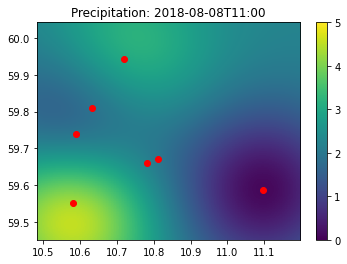

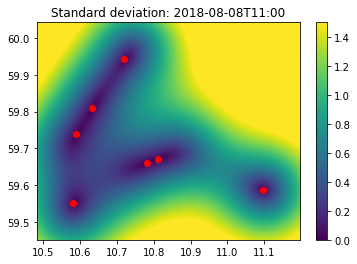

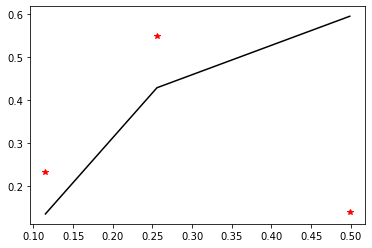

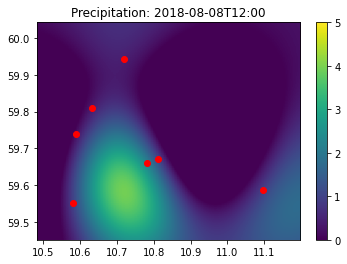

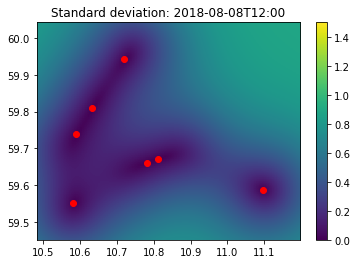

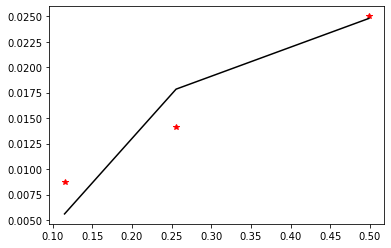

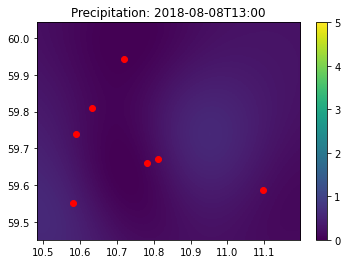

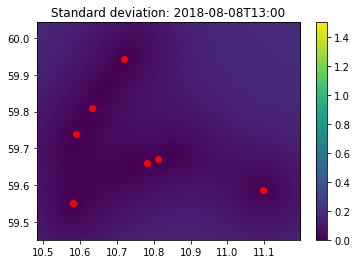

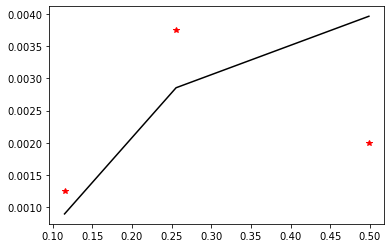

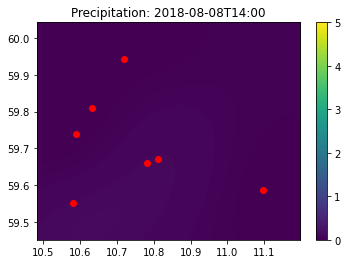

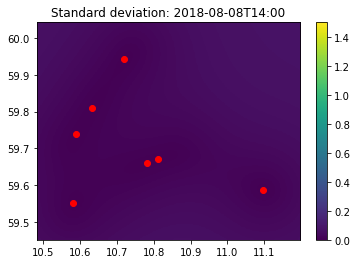

In [29]:
# note: The variogram was found differently, here by 

sill_list = [1.0, 0.2, 1.2, 3.5, 0.6, 0.025, 0.004]

from pykrige.ok import OrdinaryKriging as pykrige
for t_i in range(len(stations[0]['time'])): # time index
    p = p_data[:, t_i]
    OK = pykrige(
        x_data, #x-values
        y_data, #y-values
        p, # precipitation
        variogram_model="gaussian",
        variogram_parameters = {'sill':sill_list[t_i], 'range':0.4, 'nugget':0},
        enable_plotting=True, 
        nlags = 3, #number of averaging bins
        pseudo_inv = True
    )
    
    z_grid_intp, z_grid_sigma = OK.execute("grid", x_grid, y_grid)
    z_grid_sigma = np.sqrt(z_grid_sigma)
    plt.imshow(z_grid_intp, extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()],
           vmin=z_grid_intp.min(), vmax=z_grid_intp.max())
    plt.clim(0,5)
    plt.colorbar()
    
    plt.title("Precipitation: " + stations[0].time.values[t_i][0:16])
    plt.scatter(x_data, y_data, c='red', marker='o')
    plt.show()
    
    
    plt.imshow(z_grid_sigma, extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()],
           vmin=z_grid_intp.min(), vmax=z_grid_intp.max())
    plt.clim(0,1.5)
    plt.colorbar()
    plt.title("Standard deviation: " + stations[0].time.values[t_i][0:16])
    plt.scatter(x_data, y_data, c='red', marker='o')
    plt.show()